In [103]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import  accuracy_score,precision_score,f1_score,recall_score, confusion_matrix,classification_report,roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import GradientBoostingClassifier , RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

In [104]:
df = pd.read_csv('/content/StressLevelDataset.csv')
df.head()

,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,safety,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
0,14,20,0,11,2,1,2,4,2,3,3,2,3,2,3,3,2,3,3,2,1
1,15,8,1,15,5,3,1,4,3,1,2,2,1,4,1,5,1,4,5,5,2
2,12,18,1,14,2,1,2,2,2,2,3,2,2,3,3,2,2,3,2,2,1
3,16,12,1,15,4,3,1,3,4,2,2,2,2,4,1,4,1,4,4,5,2
4,16,28,0,7,2,3,5,1,3,2,4,3,4,3,1,2,1,5,0,5,1


In [105]:

def cleaning(df):
    df.drop('Timestamp', axis=1, inplace =True)
    mapping = {
        'Not at all': 0,
        'Several days': 1,
        'More than half the days': 2,
        'Nearly every day': 3
    }
    for col in df.iloc[:, :7]:
      df[col] = df[col].map(mapping)

    df['anxiety_level'] = df.iloc[:, :7].sum(axis=1)
    df['self_esteem'] = df.iloc[:, 7:17].sum(axis=1)
    for col in df.iloc[:, 18:27]:
      df[col] = df[col].map(mapping)
    df['depression'] = df.iloc[:, 18:27].sum(axis=1)
    df.drop(columns=df.columns[:7], inplace=True)
    df.drop(columns=df.columns[:10], inplace=True)
    df.drop(columns=df.columns[1:10], inplace=True)
    col = df.pop('anxiety_level')
    df.insert(0, 'anxiety_level', col)
    col = df.pop('self_esteem')
    df.insert(1, 'self_esteem', col)
    col = df.pop('depression')
    df.insert(3, 'depression', col)
    df['mental health problems history'] = df['mental health problems history'].map( {
        'never experienced mental health problem before': 0,
        'experienced mental health problem before': 1})
    df['Blood Pressure'] = df['Blood Pressure'].map( {
        'low': 0,
        'mid': 1,
        'high': 2,
        "I don't know": 1})
    df['How frequent you experience short and heavy breathing'] = df['How frequent you experience short and heavy breathing'].map(mapping)
    df['Do you have social support to cope with mental health?'] = df['Do you have social support to cope with mental health?'].map( {
        'No': 0,
        'Maybe': 1,
        'Yes': 2})
    df.rename(columns={
        'mental health problems history': 'mental_health_history',
        'headache frequency':'headache',
        'Blood Pressure':'blood_pressure',
        'Sleep quality':'sleep_quality',
        'How frequent you experience short and heavy breathing':'breathing_problem',
        'How loud is the place you live?':'noise_level',
        'How good is your living condition?':'living_conditions',
        'How safe do you feel overall?':'safety',
        'do you get all your basic needs?':'basic_needs',
        'how is our academic performance':'academic_performance',
        'how is your study load':'study_load',
        'how is your relationship with teachers':'teacher_student_relationship',
        'how are you concerned with your future career ':'future_career_concerns',
        'Do you have social support to cope with mental health?':'social_support',
        'Do you experience peer pressure?':'peer_pressure',
        'Do you engage yourself in extracurricular activities?':'extracurricular_activities',
        'Do you experience bullying?':'bullying',
        'how stressed are you?':'stress_level',
    }, inplace=True)
    return df



In [106]:
# data obtained by survey done in aurak.
Aurak_df = pd.read_csv('/content/stress measure form(Responses) - Form responses 1 (1).csv')
Aurak_df = cleaning(Aurak_df)
Aurak_df.head()

,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,safety,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
0,5.0,19.0,0.0,8.0,3.0,2.0,5.0,3,4.0,4.0,2.0,5.0,5.0,5.0,1.0,3.0,0.0,1.0,1.0,3.0,1.0
1,16.0,7.0,1.0,21.0,3.0,2.0,2.0,1,4.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,0.0,3.0,1.0,1.0,1.0
2,7.0,15.0,0.0,10.0,1.0,1.0,1.0,1,3.0,5.0,4.0,3.0,4.0,5.0,5.0,5.0,1.0,2.0,1.0,1.0,2.0
3,3.0,21.0,0.0,8.0,1.0,1.0,4.0,1,2.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,1.0,1.0,1.0,1.0,0.0
4,11.0,21.0,0.0,13.0,3.0,1.0,3.0,1,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,1.0,3.0,3.0,3.0,1.0


In [107]:
Aurak_df.dropna(inplace=True)

In [108]:
Aurak_df = Aurak_df.astype(np.int64)

In [109]:
Aurak_df_x = Aurak_df.iloc[:,:-1]
Aurak_df_y = Aurak_df.iloc[:,-1]

## EDA

In [110]:
df.shape

(1100, 21)

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   anxiety_level                 1100 non-null   int64
 1   self_esteem                   1100 non-null   int64
 2   mental_health_history         1100 non-null   int64
 3   depression                    1100 non-null   int64
 4   headache                      1100 non-null   int64
 5   blood_pressure                1100 non-null   int64
 6   sleep_quality                 1100 non-null   int64
 7   breathing_problem             1100 non-null   int64
 8   noise_level                   1100 non-null   int64
 9   living_conditions             1100 non-null   int64
 10  safety                        1100 non-null   int64
 11  basic_needs                   1100 non-null   int64
 12  academic_performance          1100 non-null   int64
 13  study_load                    110

In [112]:
pd.set_option('display.max_columns', None)

In [113]:
df.describe()

,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,safety,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
count,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000
mean,11.063636,17.777273,0.492727,12.555455,2.508182,2.181818,2.660000,2.753636,2.649091,2.518182,2.737273,2.772727,2.772727,2.621818,2.648182,2.649091,1.881818,2.734545,2.767273,2.617273,0.996364
std,6.117558,8.944599,0.500175,7.727008,1.409356,0.833575,1.548383,1.400713,1.328127,1.119208,1.406171,1.433761,1.414594,1.315781,1.384579,1.529375,1.047826,1.425265,1.417562,1.530958,0.821673
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,11.000000,0.000000,6.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,0.000000
50%,11.000000,19.000000,0.000000,12.000000,3.000000,2.000000,2.500000,3.000000,3.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.500000,3.000000,1.000000
75%,16.000000,26.000000,1.000000,19.000000,3.000000,3.000000,4.000000,4.000000,3.000000,3.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,3.000000,4.000000,4.000000,4.000000,2.000000
max,21.000000,30.000000,1.000000,27.000000,5.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,5.000000,5.000000,5.000000,2.000000


In [114]:
df.isna().sum()

,0
anxiety_level,0
self_esteem,0
mental_health_history,0
depression,0
headache,0
blood_pressure,0
sleep_quality,0
breathing_problem,0
noise_level,0
living_conditions,0


In [115]:
df.duplicated().sum()

0

In [116]:
# checking the range of each column
for column in df.columns:
  print(f'the range in column {column} is [ {df[column].min()}-{df[column].max()} ]')

the range in column anxiety_level is [ 0-21 ]
the range in column self_esteem is [ 0-30 ]
the range in column mental_health_history is [ 0-1 ]
the range in column depression is [ 0-27 ]
the range in column headache is [ 0-5 ]
the range in column blood_pressure is [ 1-3 ]
the range in column sleep_quality is [ 0-5 ]
the range in column breathing_problem is [ 0-5 ]
the range in column noise_level is [ 0-5 ]
the range in column living_conditions is [ 0-5 ]
the range in column safety is [ 0-5 ]
the range in column basic_needs is [ 0-5 ]
the range in column academic_performance is [ 0-5 ]
the range in column study_load is [ 0-5 ]
the range in column teacher_student_relationship is [ 0-5 ]
the range in column future_career_concerns is [ 0-5 ]
the range in column social_support is [ 0-3 ]
the range in column peer_pressure is [ 0-5 ]
the range in column extracurricular_activities is [ 0-5 ]
the range in column bullying is [ 0-5 ]
the range in column stress_level is [ 0-2 ]


In [117]:
#checking unique values in each column
for column in df.columns:
  print(f'Unique values in {column}: {df[column].unique()}')

Unique values in anxiety_level: [14 15 12 16 20  4 17 13  6  5  9  2 11  7 21  3 18  0  8  1 19 10]
Unique values in self_esteem: [20  8 18 12 28 13 26  3 22 15 23 21 25  1 27  5  6  9 29 30  4 19 16  2
  0 14  7 17 24 11 10]
Unique values in mental_health_history: [0 1]
Unique values in depression: [11 15 14  7 21  6 22 12 27 25  8 24  3  1  0  5 26 20 10  9  2 16  4 13
 18 23 17 19]
Unique values in headache: [2 5 4 3 1 0]
Unique values in blood_pressure: [1 3 2]
Unique values in sleep_quality: [2 1 5 4 3 0]
Unique values in breathing_problem: [4 2 3 1 5 0]
Unique values in noise_level: [2 3 4 1 0 5]
Unique values in living_conditions: [3 1 2 4 5 0]
Unique values in safety: [3 2 4 1 5 0]
Unique values in basic_needs: [2 3 1 4 5 0]
Unique values in academic_performance: [3 1 2 4 5 0]
Unique values in study_load: [2 4 3 5 1 0]
Unique values in teacher_student_relationship: [3 1 2 4 5 0]
Unique values in future_career_concerns: [3 5 2 4 1 0]
Unique values in social_support: [2 1 3 0]
Un

stress_level
0    373
2    369
1    358
Name: count, dtype: int64


<ipython-input-118-145684a29e53>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'stress_level', data = df,palette='Set2' )


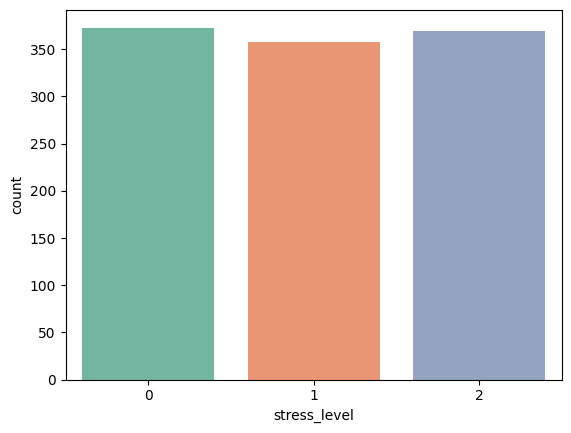

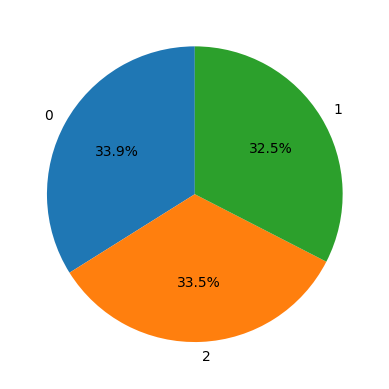

In [118]:
#checking distribution of the target
print(df['stress_level'].value_counts())
sns.countplot(x = 'stress_level', data = df,palette='Set2' )
plt.show()

counts = df['stress_level'].value_counts()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.show()

In [119]:
# mean of every column for each stress level
average_stress = df.groupby('stress_level').mean()
average_stress

,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,safety,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying
stress_level,,,,,,,,,,,,,,,,,,,,
0,5.431635,25.252011,0.101877,6.013405,1.313673,2.195710,4.126005,1.697051,1.648794,3.313673,4.099196,4.144772,4.142091,1.654155,3.927614,1.335121,2.541555,1.675603,1.715818,1.254692
1,11.430168,19.262570,0.488827,11.874302,2.460894,1.324022,2.530726,2.927374,2.511173,2.502793,2.416201,2.477654,2.491620,2.533520,2.357542,2.522346,2.178771,2.458101,2.480447,2.555866
2,16.401084,8.780488,0.891599,19.829268,3.761518,3.000000,1.303523,3.653117,3.794038,1.728997,1.672087,1.672087,1.661247,3.685637,1.636856,4.100271,0.926829,4.073171,4.108401,4.054201


In [120]:
# see how people are affected with different categories of factors
#phsycological ,physiological, enviromental, acedemic, social
factors= {
  'Psychological': {'anxiety_level':10, 'self_esteem':-15, 'mental_health_history':0, 'depression':10},
  'Physiological': {'headache':2, 'blood_pressure':1, 'sleep_quality':-3, 'breathing_problem':2},
  'Environmental': {'noise_level':2, 'living_conditions':-3, 'safety':-3, 'basic_needs':2},
  'Academic': {'academic_performance':-3, 'study_load':2, 'teacher_student_relationship':-3, 'future_career_concerns':2},
  'Social': {'social_support':-2, 'peer_pressure':2, 'extracurricular_activities':2, 'bullying':2} }

affected={}
for factor,value in factors.items():
  affected[factor]=0
  for column,threshold in value.items():
      if threshold > 0:
        a= df[(df[column] > threshold) & (df['stress_level'] > 0)].count().iloc[1]
        affected[factor] += a
      else:
        a= df[(df[column] < -threshold) & (df['stress_level'] > 0)].count().iloc[1]
        affected[factor] += a
      print(f'column {column} play part in affecting {a} people with stress')

print(affected)

column anxiety_level play part in affecting 554 people with stress
column self_esteem play part in affecting 348 people with stress
column mental_health_history play part in affecting 0 people with stress
column depression play part in affecting 577 people with stress
column headache play part in affecting 515 people with stress
column blood_pressure play part in affecting 427 people with stress
column sleep_quality play part in affecting 516 people with stress
column breathing_problem play part in affecting 514 people with stress
column noise_level play part in affecting 528 people with stress
column living_conditions play part in affecting 515 people with stress
column safety play part in affecting 527 people with stress
column basic_needs play part in affecting 213 people with stress
column academic_performance play part in affecting 525 people with stress
column study_load play part in affecting 509 people with stress
column teacher_student_relationship play part in affecting 532 p

<ipython-input-121-0f5757f25347>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Factor', y='Total_Affected', data=a, palette='Set2')


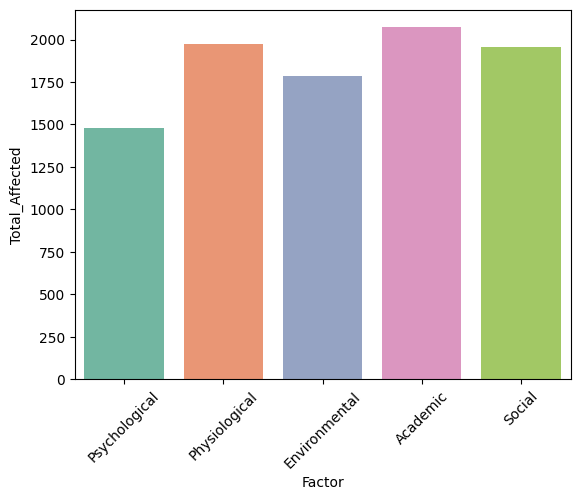

In [121]:
# visualizing the above
a = pd.DataFrame(list(affected.items()), columns=['Factor', 'Total_Affected'])
sns.barplot(x='Factor', y='Total_Affected', data=a, palette='Set2')
plt.xticks(rotation=45)
plt.show()


correlation matrix of Psychological factor with stress


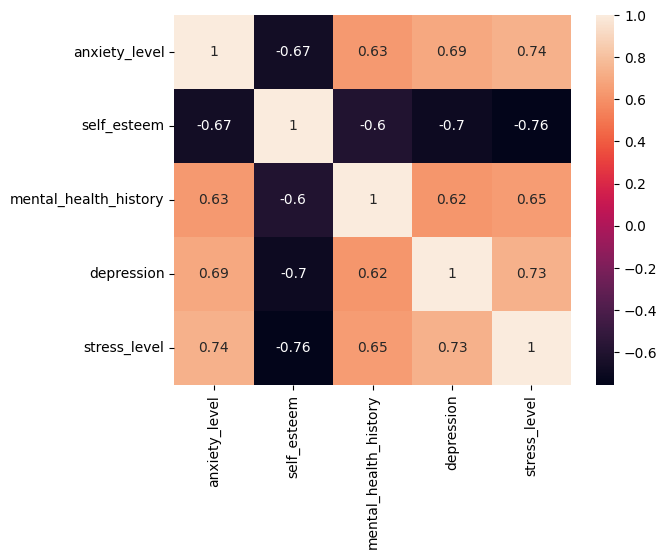

correlation matrix of Physiological factor with stress


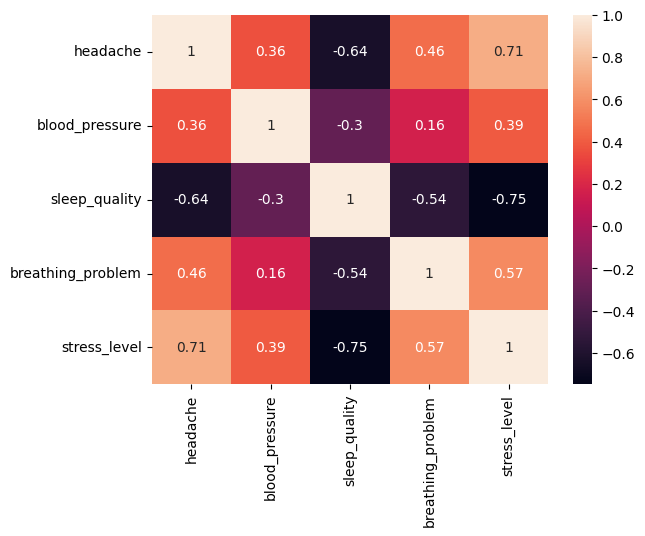

correlation matrix of Environmental factor with stress


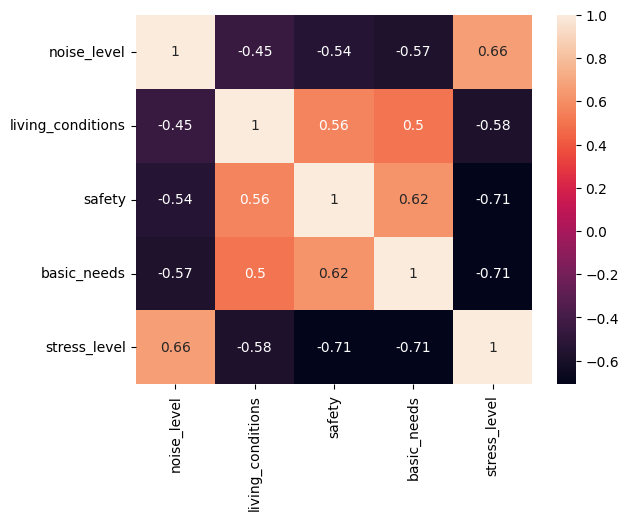

correlation matrix of Academic factor with stress


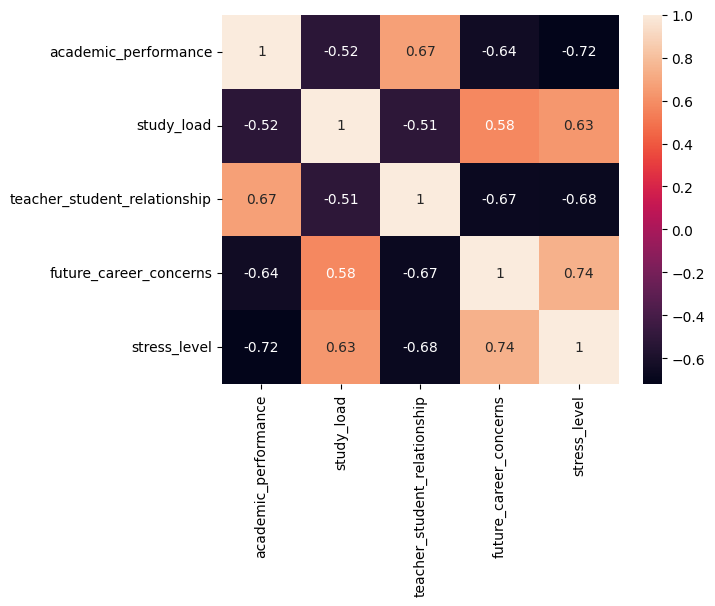

correlation matrix of Social factor with stress


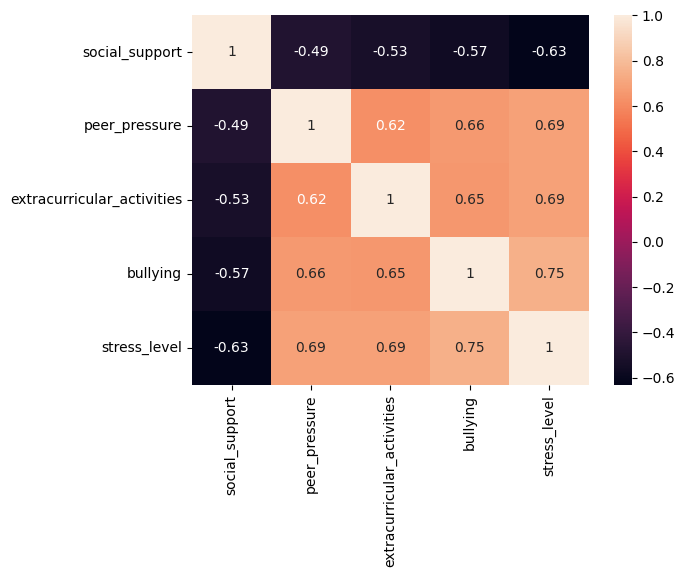

In [122]:
# checking the coorelation of each category of factor with stress
for factor,value in factors.items():
  print(f"correlation matrix of {factor} factor with stress")
  a= pd.DataFrame()
  for column,threshold in value.items():
    a[column] = df[column]
  a['stress_level'] = df['stress_level']
  sns.heatmap(a.corr(), annot=True)
  plt.show()

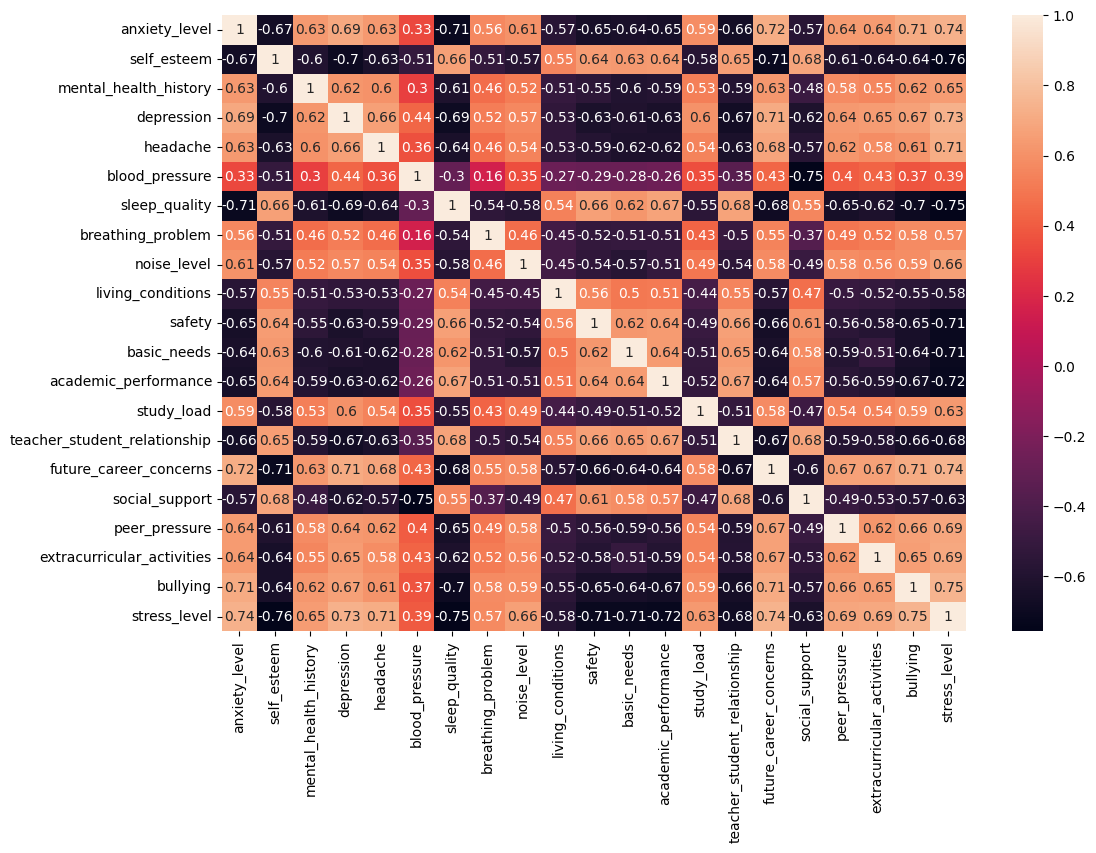

In [123]:
#corelation of everything to everything
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True)
plt.show()

column anxiety_level is disrtibuted as follow
stress_level  anxiety_level
0             7                46
              2                41
              3                41
              6                41
              8                41
                               ..
2             0                 2
              8                 2
              10                2
              4                 1
              13                1
Name: count, Length: 63, dtype: int64


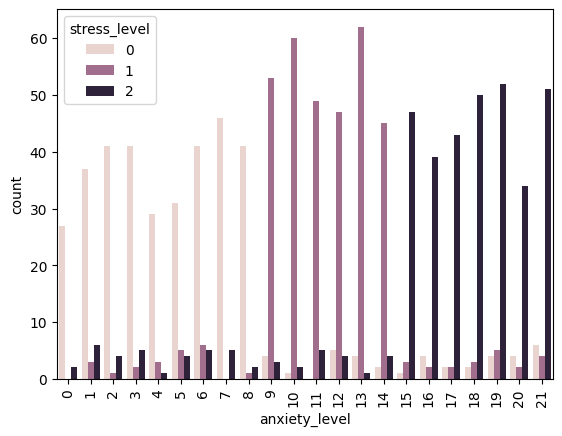

column self_esteem is disrtibuted as follow
stress_level  self_esteem
0             30             58
              26             56
              25             55
              27             54
              29             49
                             ..
2             24              2
              28              2
              25              1
              26              1
              30              1
Name: count, Length: 82, dtype: int64


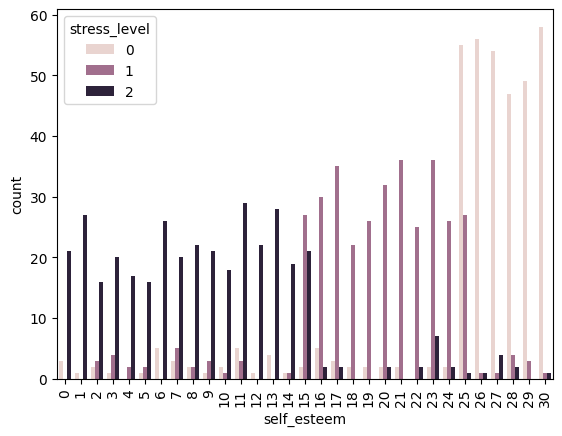

column mental_health_history is disrtibuted as follow
stress_level  mental_health_history
0             0                        335
              1                         38
1             0                        183
              1                        175
2             1                        329
              0                         40
Name: count, dtype: int64


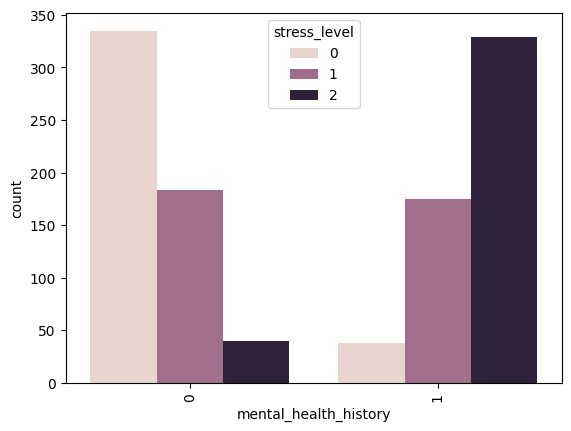

column depression is disrtibuted as follow
stress_level  depression
0             8             46
              3             42
              5             39
              0             36
              2             34
                            ..
2             8              3
              14             3
              3              2
              5              1
              11             1
Name: count, Length: 76, dtype: int64


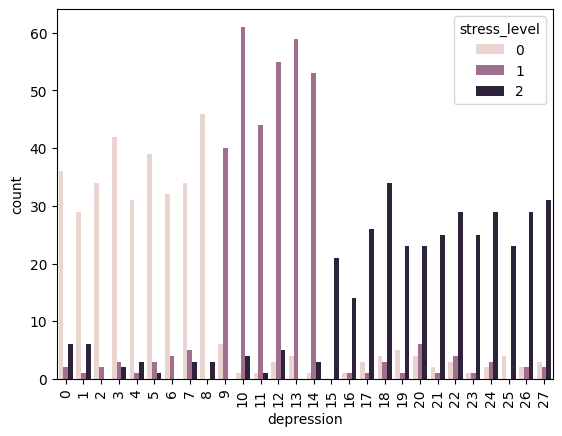

column headache is disrtibuted as follow
stress_level  headache
0             1           312
              3            15
              4            13
              5            13
              0            12
              2             8
1             2           167
              3           153
              0            11
              1            10
              5            10
              4             7
2             4           120
              3           119
              5           106
              0             9
              1             9
              2             6
Name: count, dtype: int64


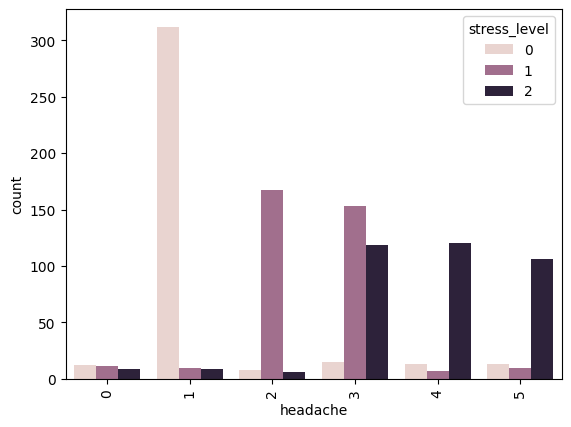

column blood_pressure is disrtibuted as follow
stress_level  blood_pressure
0             2                 300
              3                  73
1             1                 300
              3                  58
2             3                 369
Name: count, dtype: int64


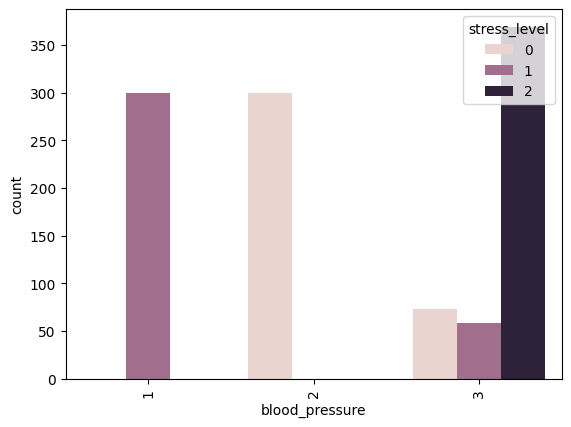

column sleep_quality is disrtibuted as follow
stress_level  sleep_quality
0             5                163
              4                162
              3                 14
              0                 13
              2                 13
              1                  8
1             2                170
              3                144
              4                 17
              5                 12
              0                  9
              1                  6
2             1                314
              5                 17
              0                 12
              3                 12
              4                  9
              2                  5
Name: count, dtype: int64


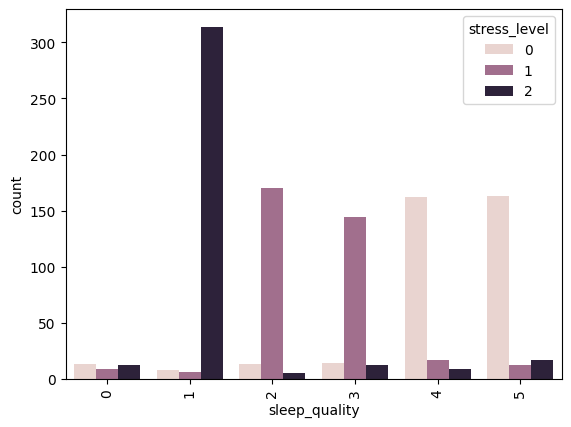

column breathing_problem is disrtibuted as follow
stress_level  breathing_problem
0             2                    161
              1                    154
              0                     19
              4                     14
              5                     13
              3                     12
1             4                    165
              2                    148
              0                     13
              1                     13
              5                     11
              3                      8
2             3                    119
              4                    108
              5                    103
              2                     16
              1                     12
              0                     11
Name: count, dtype: int64


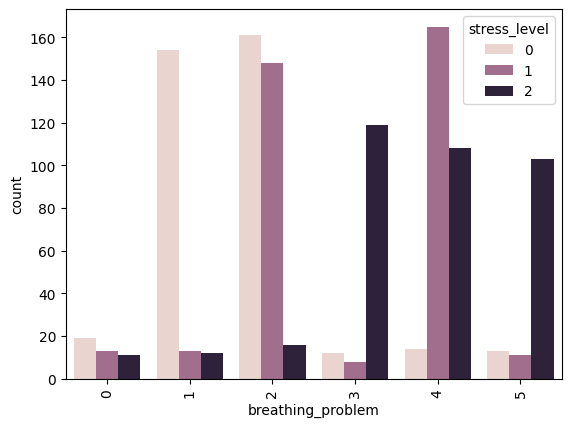

column noise_level is disrtibuted as follow
stress_level  noise_level
0             1              170
              2              150
              0               18
              5               15
              3               10
              4               10
1             3              171
              2              151
              1               11
              0                9
              5                9
              4                7
2             4              120
              5              113
              3              108
              2               12
              0                9
              1                7
Name: count, dtype: int64


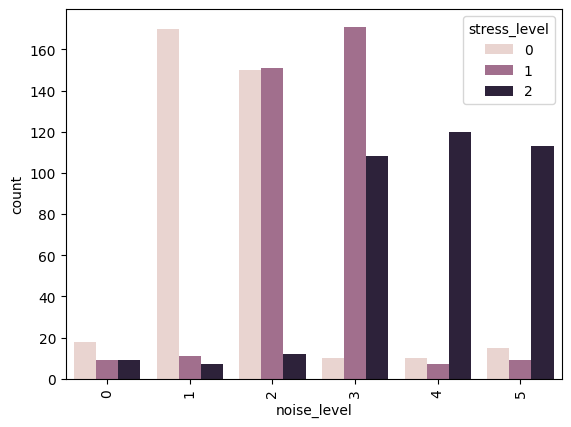

column living_conditions is disrtibuted as follow
stress_level  living_conditions
0             4                    172
              3                    155
              1                     15
              0                     12
              5                     10
              2                      9
1             2                    163
              3                    161
              5                     10
              1                      9
              0                      8
              4                      7
2             2                    174
              1                    152
              5                     13
              3                     11
              4                     10
              0                      9
Name: count, dtype: int64


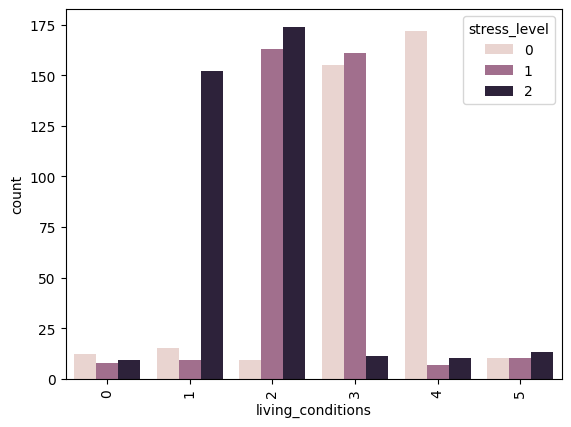

column safety is disrtibuted as follow
stress_level  safety
0             4         166
              5         157
              2          15
              1          14
              3          12
              0           9
1             2         168
              3         153
              1          15
              0          10
              5           7
              4           5
2             2         165
              1         155
              3          15
              0          14
              4          13
              5           7
Name: count, dtype: int64


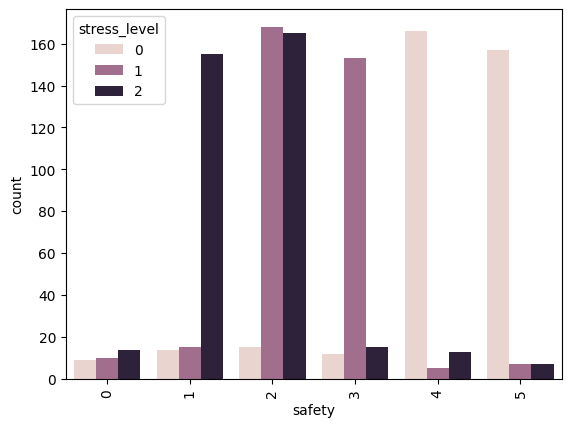

column basic_needs is disrtibuted as follow
stress_level  basic_needs
0             5              170
              4              155
              3               14
              1               12
              0               11
              2               11
1             3              162
              2              156
              0               14
              4                9
              5                9
              1                8
2             2              168
              1              153
              0               15
              3               14
              5               10
              4                9
Name: count, dtype: int64


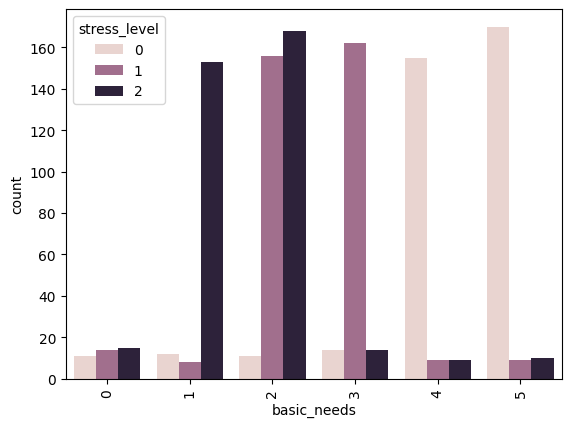

column academic_performance is disrtibuted as follow
stress_level  academic_performance
0             4                       165
              5                       164
              2                        16
              0                        11
              1                         9
              3                         8
1             2                       170
              3                       150
              4                        12
              1                         9
              5                         9
              0                         8
2             1                       167
              2                       162
              3                        11
              4                        11
              0                         9
              5                         9
Name: count, dtype: int64


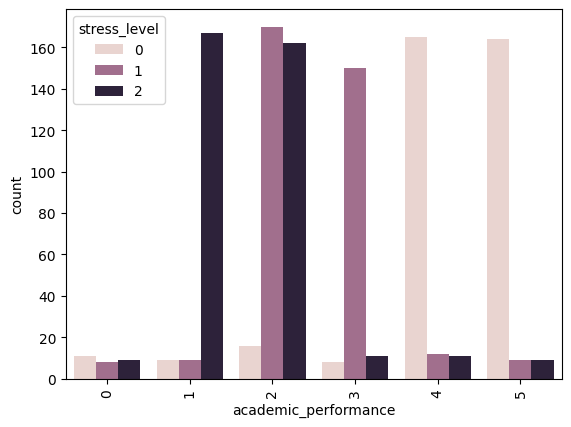

column study_load is disrtibuted as follow
stress_level  study_load
0             1             166
              2             154
              0              17
              4              13
              3              12
              5              11
1             2             167
              3             152
              5              13
              4              12
              0              10
              1               4
2             4             117
              3             111
              5             104
              1              15
              2              12
              0              10
Name: count, dtype: int64


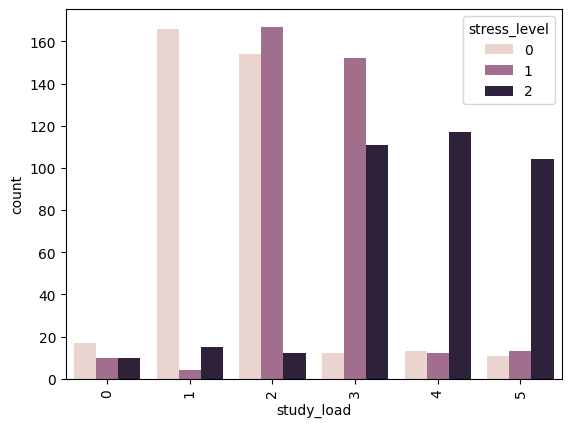

column teacher_student_relationship is disrtibuted as follow
stress_level  teacher_student_relationship
0             4                               171
              5                               140
              2                                21
              0                                20
              1                                12
              3                                 9
1             2                               170
              3                               154
              1                                14
              0                                13
              4                                 7
2             1                               164
              2                               162
              3                                20
              4                                14
              0                                 9
Name: count, dtype: int64


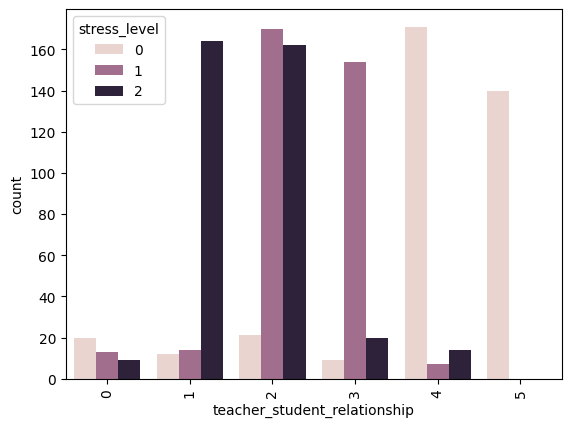

column future_career_concerns is disrtibuted as follow
stress_level  future_career_concerns
0             1                         313
              2                          15
              4                          15
              5                          13
              3                          10
              0                           7
1             2                         172
              3                         151
              4                          12
              5                          11
              0                           9
              1                           3
2             5                         162
              4                         158
              0                          14
              2                          12
              3                          12
              1                          11
Name: count, dtype: int64


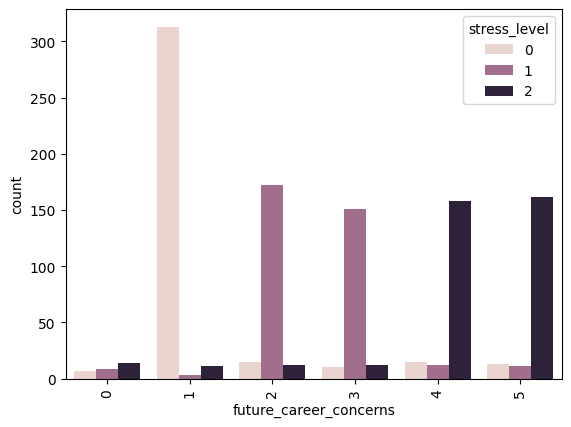

column social_support is disrtibuted as follow
stress_level  social_support
0             3                 300
              1                  48
              0                  25
1             3                 158
              2                 142
              0                  36
              1                  22
2             1                 342
              0                  27
Name: count, dtype: int64


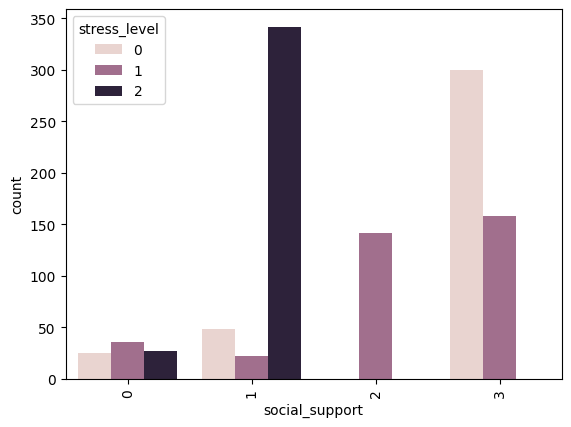

column peer_pressure is disrtibuted as follow
stress_level  peer_pressure
0             2                173
              1                151
              0                 17
              4                 12
              3                 10
              5                 10
1             2                168
              3                152
              1                 11
              0                 10
              5                  9
              4                  8
2             5                162
              4                154
              1                 19
              2                 14
              0                 10
              3                 10
Name: count, dtype: int64


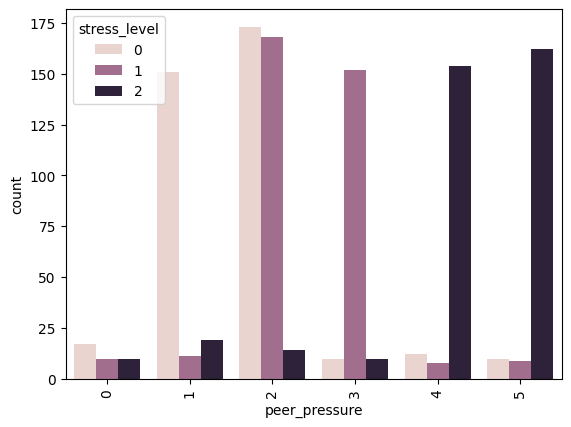

column extracurricular_activities is disrtibuted as follow
stress_level  extracurricular_activities
0             1                             162
              2                             159
              4                              14
              3                              13
              5                              13
              0                              12
1             2                             166
              3                             156
              4                              11
              0                               9
              1                               9
              5                               7
2             4                             173
              5                             154
              0                              13
              1                              13
              3                               9
              2                               7
Name: count, dtype: int64


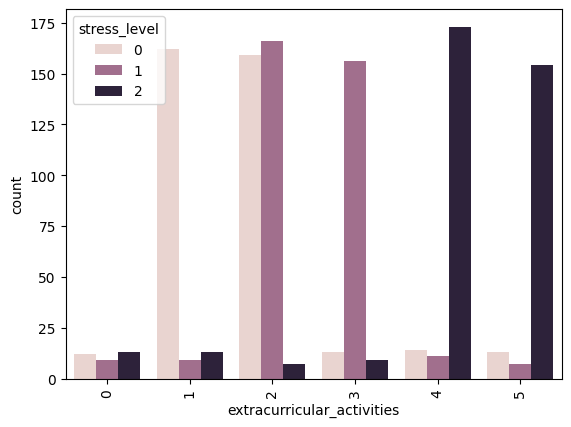

column bullying is disrtibuted as follow
stress_level  bullying
0             1           312
              0            15
              2            14
              3            13
              5            13
              4             6
1             3           175
              2           141
              0            12
              5            12
              4            10
              1             8
2             4           171
              5           148
              1            15
              0            12
              2            12
              3            11
Name: count, dtype: int64


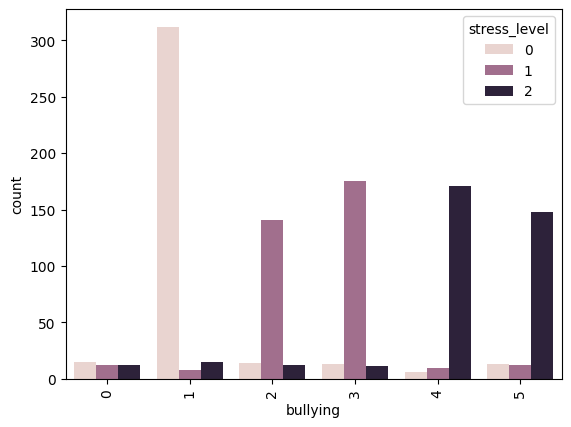

column stress_level is disrtibuted as follow
stress_level
0    373
1    358
2    369
Name: count, dtype: int64


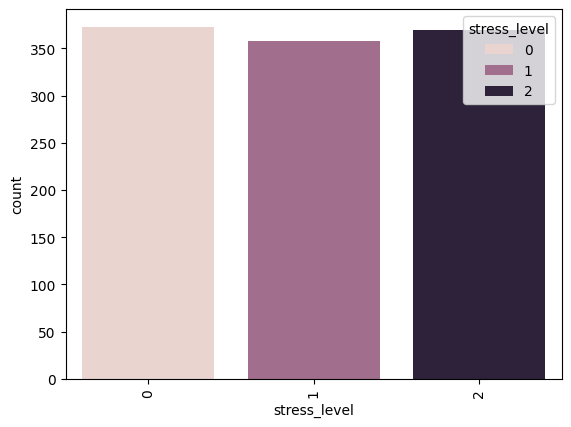

In [124]:
#how each column is distributed
for column in df.columns:
  print(f'column {column} is disrtibuted as follow')
  print(df.groupby('stress_level')[column].value_counts())
  sns.countplot(x =column,data = df, hue = 'stress_level')
  plt.xticks(rotation =90)
  plt.show()

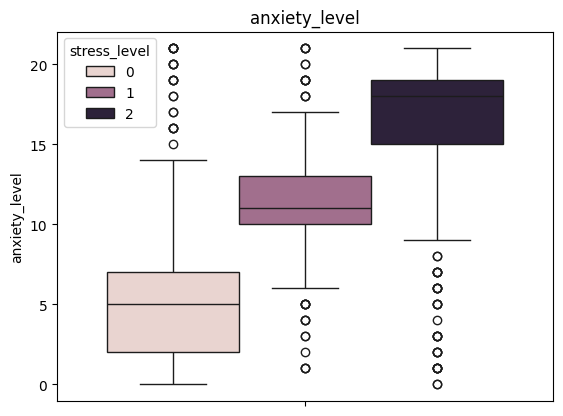

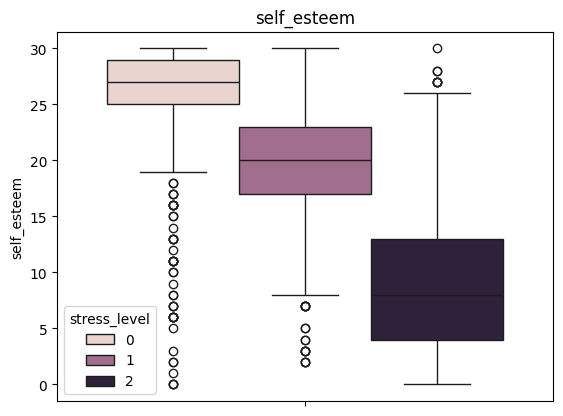

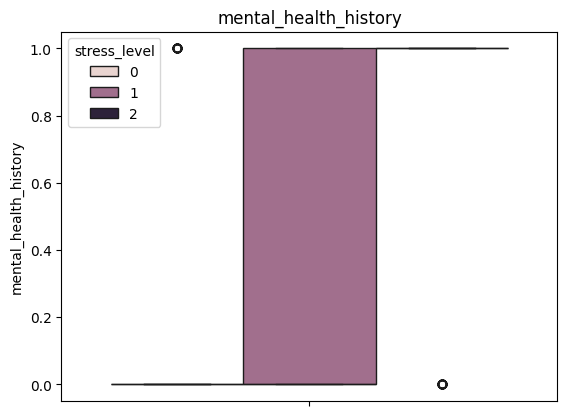

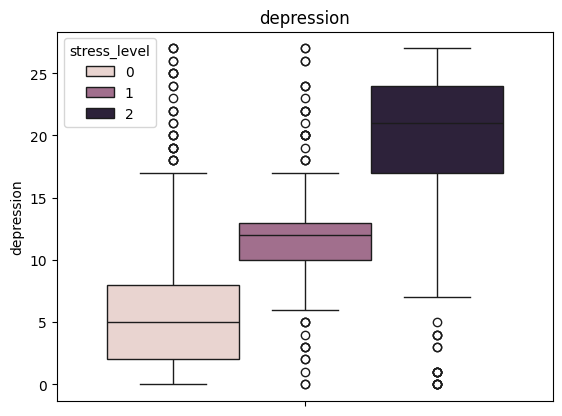

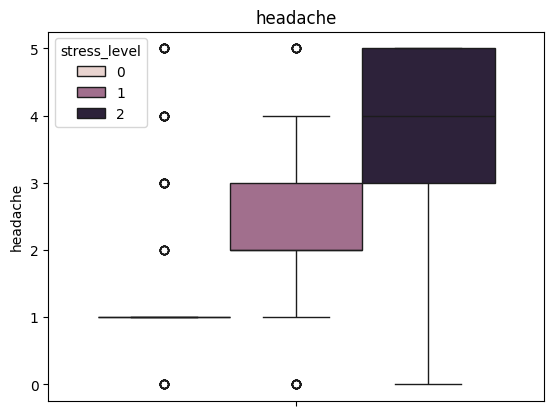

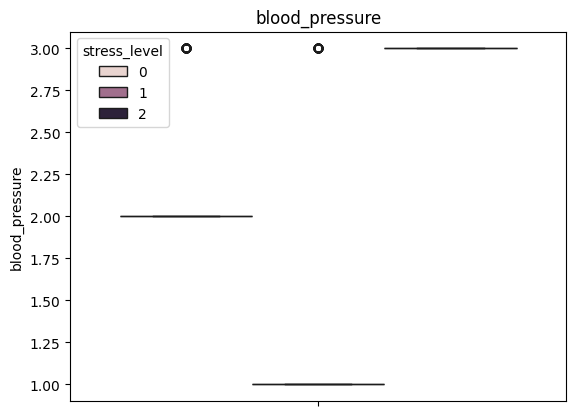

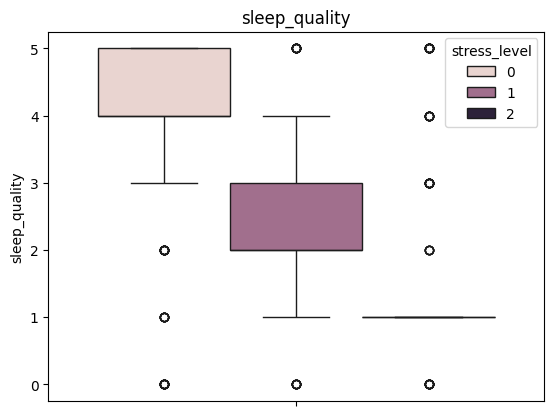

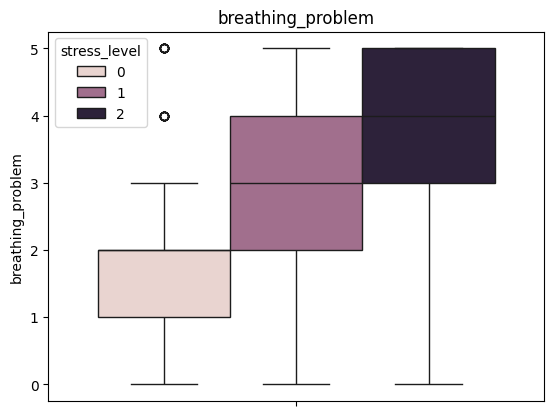

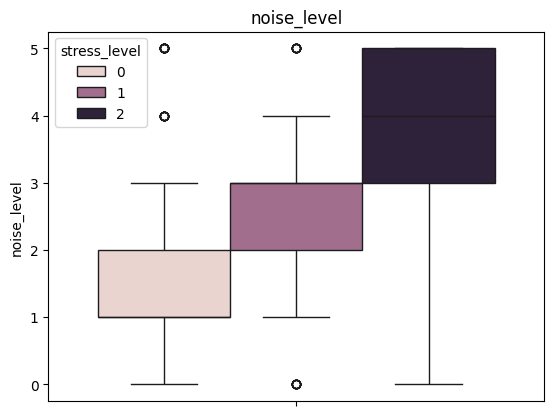

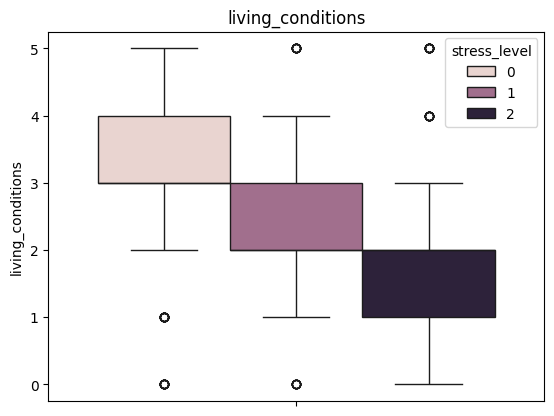

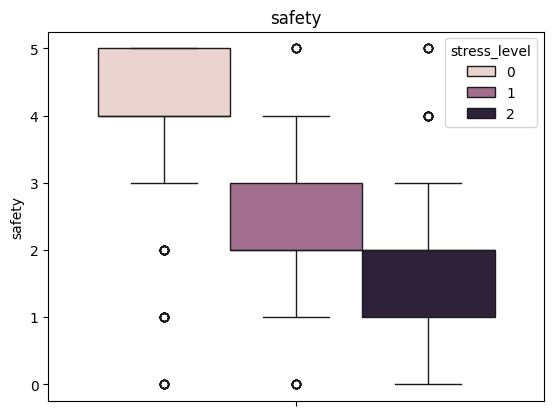

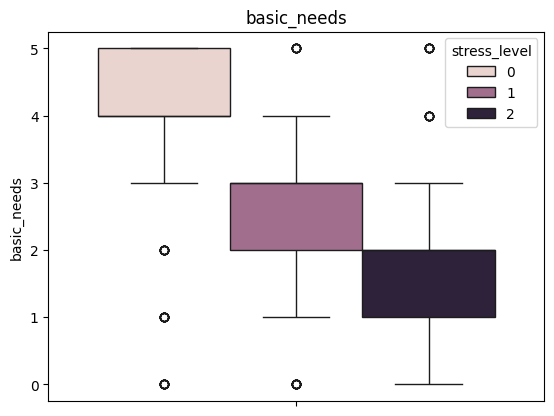

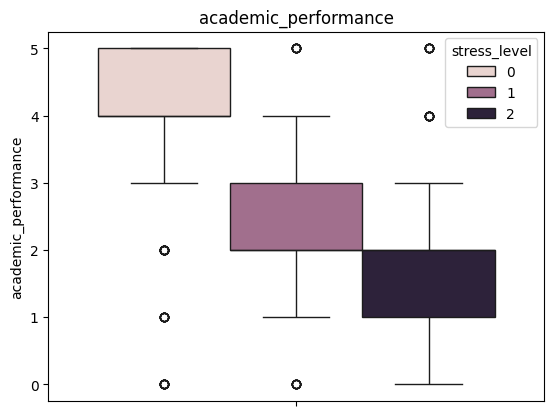

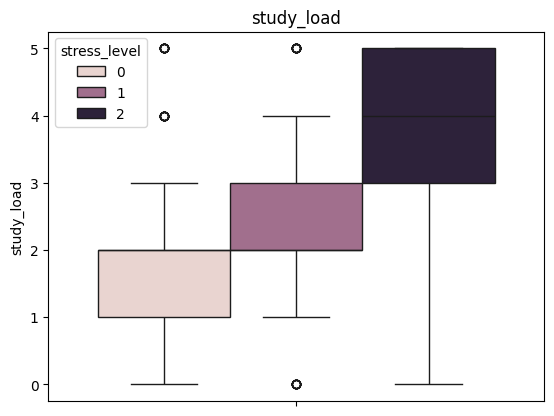

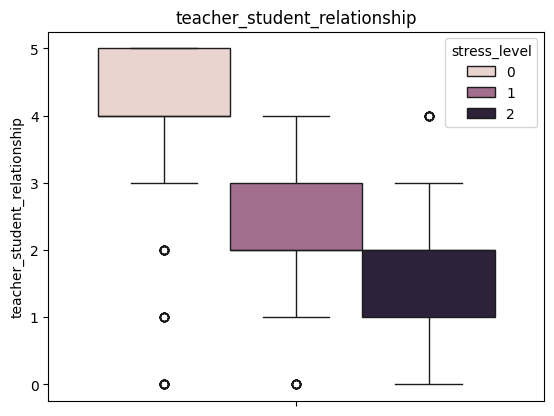

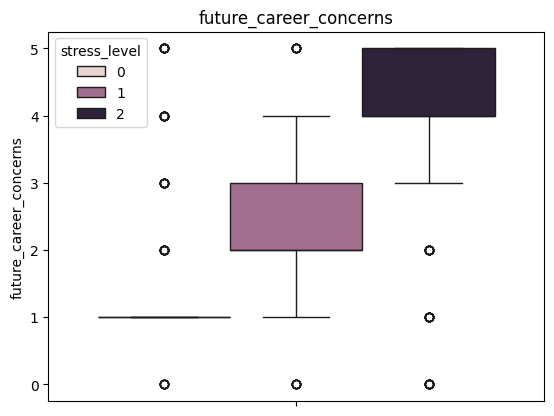

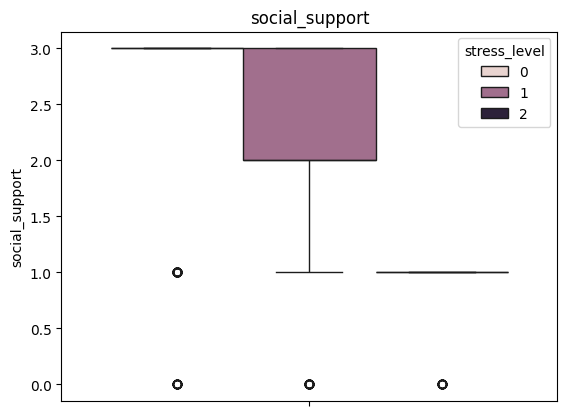

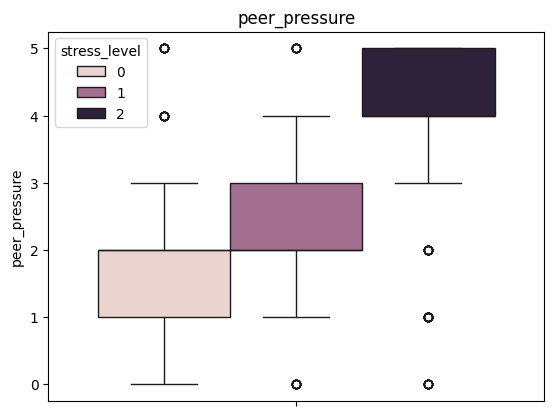

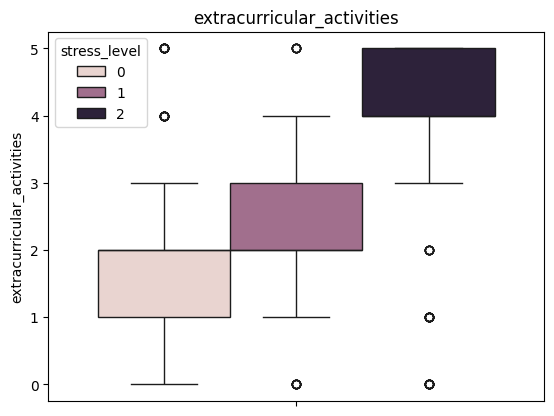

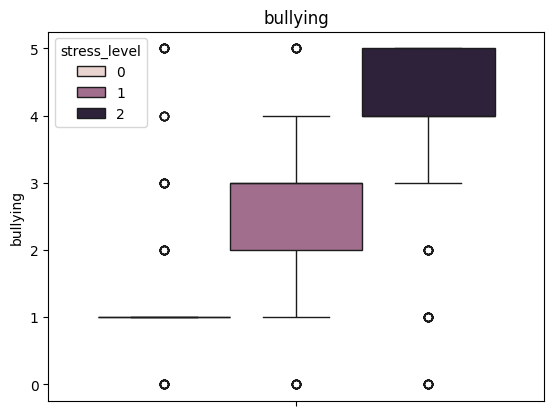

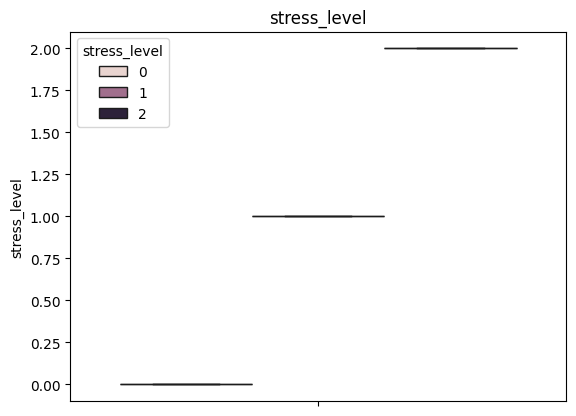

In [125]:
#box plot of each column to stress
for column in df.columns:
  sns.boxplot(y =column,data = df, hue = 'stress_level')
  plt.title(column)
  plt.show()

## starts training

## MLP

In [126]:
#training artificial neural network
X = df.drop('stress_level', axis=1).values
y = df['stress_level'].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y.reshape(-1, 1))
y_encoded = y_encoded.toarray() #To convert from sparse array to numpy array
# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float)
y_tensor = torch.tensor(y_encoded, dtype=torch.float)
X_train, X_test, y_train_nn, y_test_nn = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train_nn)
test_dataset = TensorDataset(X_test, y_test_nn)

batch_size = 16
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 12) # 20 to 12 to 3
        self.fc2 = nn.Linear(12, 6)
        self.fc3 = nn.Linear(6, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MLP(input_size=X_train.shape[1], output_size=y_train_nn.shape[1])

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
epochs = 100
for epoch in tqdm(range(epochs)):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    #Printing the loss every N epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []

    for inputs, targets in test_loader:
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim=1)
        actual = torch.argmax(targets, dim=1)

        y_true.extend(actual.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

report = classification_report(y_true, y_pred)
print(report)

 12%|█▏        | 12/100 [00:00<00:06, 12.62it/s]

Epoch 10, Loss: 0.09891056269407272


 22%|██▏       | 22/100 [00:01<00:06, 12.85it/s]

Epoch 20, Loss: 0.22076529264450073


 32%|███▏      | 32/100 [00:02<00:05, 13.26it/s]

Epoch 30, Loss: 0.09716657549142838


 42%|████▏     | 42/100 [00:03<00:04, 13.06it/s]

Epoch 40, Loss: 0.08672487735748291


 52%|█████▏    | 52/100 [00:04<00:03, 12.80it/s]

Epoch 50, Loss: 0.041329558938741684


 62%|██████▏   | 62/100 [00:04<00:02, 12.91it/s]

Epoch 60, Loss: 0.06091674789786339


 72%|███████▏  | 72/100 [00:05<00:02, 13.06it/s]

Epoch 70, Loss: 0.03014170564711094


 82%|████████▏ | 82/100 [00:06<00:01, 13.05it/s]

Epoch 80, Loss: 0.10898363590240479


 92%|█████████▏| 92/100 [00:07<00:00, 12.70it/s]

Epoch 90, Loss: 0.1177188977599144


100%|██████████| 100/100 [00:07<00:00, 12.95it/s]

Epoch 100, Loss: 0.06822415441274643
              precision    recall  f1-score   support

           0       0.90      0.87      0.89        76
           1       0.91      0.93      0.92        73
           2       0.89      0.90      0.90        71

    accuracy                           0.90       220
   macro avg       0.90      0.90      0.90       220
weighted avg       0.90      0.90      0.90       220



In [127]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [128]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=0)


In [129]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

In [130]:
param_grid = {'n_neighbors': list(range(1,30))}
knn_model = KNeighborsClassifier()
g_search = GridSearchCV(knn_model,param_grid,cv=5,scoring='accuracy')
g_search.fit(x_train_scaled,y_train)
optimal_k = g_search.best_params_['n_neighbors']
print(f'Optimal value for k : {optimal_k}')


Optimal value for k : 3


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


## ensamble moodel

In [131]:
model1 = KNeighborsClassifier(n_neighbors = optimal_k)
model2 = SVC(kernel='linear')
model3 = DecisionTreeClassifier()

ensemble = VotingClassifier(estimators=[
    ('knn', model1), ('svc', model2), ('dt', model3)],
    voting='hard')# mahority class

ensemble.fit(x_train, y_train)
y_pred = ensemble.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("confusion Matrix: ",confusion_matrix(y_test,y_pred))
print("classification_report: ",classification_report(y_test,y_pred))

Accuracy: 0.8818181818181818
confusion Matrix:  [[66  2  6]
 [ 5 70  5]
 [ 3  5 58]]
classification_report:                precision    recall  f1-score   support

           0       0.89      0.89      0.89        74
           1       0.91      0.88      0.89        80
           2       0.84      0.88      0.86        66

    accuracy                           0.88       220
   macro avg       0.88      0.88      0.88       220
weighted avg       0.88      0.88      0.88       220



In [132]:
#testing with aurak data
y_pred = ensemble.predict(Aurak_df_x)
print("Accuracy:", accuracy_score(Aurak_df_y, y_pred))
print("confusion Matrix: ",confusion_matrix(Aurak_df_y,y_pred))
print("classification_report: ",classification_report(Aurak_df_y,y_pred, zero_division=1))

Accuracy: 0.5576923076923077
confusion Matrix:  [[ 0  6  0]
 [ 0 29  1]
 [ 0 16  0]]
classification_report:                precision    recall  f1-score   support

           0       1.00      0.00      0.00         6
           1       0.57      0.97      0.72        30
           2       0.00      0.00      0.00        16

    accuracy                           0.56        52
   macro avg       0.52      0.32      0.24        52
weighted avg       0.44      0.56      0.41        52



## knn

In [133]:
#normal knn
knn_model = KNeighborsClassifier(n_neighbors = optimal_k)
knn_model.fit(x_train_scaled,y_train)
knn_model_y_predicted = knn_model.predict(x_test_scaled)
cv_scores = cross_val_score(knn_model, x_test_scaled, y_test, cv=5, scoring='accuracy')
knn_accuracy = cv_scores.mean()
knn_conf_matrix = confusion_matrix(y_test,knn_model_y_predicted)
knn_classification_report = classification_report(y_test,knn_model_y_predicted)
print(f'Confusion Matrix: \n {knn_conf_matrix}')
print(f'Classification Report: \n {knn_classification_report}')
print(f'Accuracy: \n {knn_accuracy}')

Confusion Matrix: 
 [[63  3  8]
 [ 5 70  5]
 [ 5  2 59]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.85      0.86        74
           1       0.93      0.88      0.90        80
           2       0.82      0.89      0.86        66

    accuracy                           0.87       220
   macro avg       0.87      0.87      0.87       220
weighted avg       0.88      0.87      0.87       220

Accuracy: 
 0.8727272727272727


In [134]:
#testing with aurak data
y_pred = knn_model.predict(Aurak_df_x.values)
print("Accuracy:", accuracy_score(Aurak_df_y, y_pred))
print("confusion Matrix: ",confusion_matrix(Aurak_df_y,y_pred))
print("classification_report: ",classification_report(Aurak_df_y,y_pred))

Accuracy: 0.4230769230769231
confusion Matrix:  [[ 6  0  0]
 [ 8  5 17]
 [ 2  3 11]]
classification_report:                precision    recall  f1-score   support

           0       0.38      1.00      0.55         6
           1       0.62      0.17      0.26        30
           2       0.39      0.69      0.50        16

    accuracy                           0.42        52
   macro avg       0.46      0.62      0.44        52
weighted avg       0.52      0.42      0.37        52



GB

In [135]:
#normal gradient boosting
gb_classifier = GradientBoostingClassifier(n_estimators=10,learning_rate=1.0,max_depth=2,random_state=0)
gb_classifier.fit(x_train,y_train)
y_predicted = gb_classifier.predict(x_test)
cv_scores = cross_val_score(gb_classifier, x_test, y_test, cv=5, scoring='accuracy')
gb_accuracy = cv_scores.mean()
gb_conf_matrix = confusion_matrix(y_test,y_predicted)
gb_classification_report = classification_report(y_test,y_predicted)
print(f'Confusion Matrix: \n {gb_conf_matrix}')
print(f'Classification Report: \n {gb_classification_report}')
print(f'Accuracy: \n {gb_accuracy}')

Confusion Matrix: 
 [[68  1  5]
 [ 4 69  7]
 [ 1  5 60]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.92      0.93        74
           1       0.92      0.86      0.89        80
           2       0.83      0.91      0.87        66

    accuracy                           0.90       220
   macro avg       0.89      0.90      0.90       220
weighted avg       0.90      0.90      0.90       220

Accuracy: 
 0.8636363636363636


In [136]:
#testing with aurak data
y_pred = gb_classifier.predict(Aurak_df_x)
print("Accuracy:", accuracy_score(Aurak_df_y, y_pred))
print("confusion Matrix: ",confusion_matrix(Aurak_df_y,y_pred))
print("classification_report: ",classification_report(Aurak_df_y,y_pred))

Accuracy: 0.5576923076923077
confusion Matrix:  [[ 0  6  0]
 [ 1 28  1]
 [ 1 14  1]]
classification_report:                precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.58      0.93      0.72        30
           2       0.50      0.06      0.11        16

    accuracy                           0.56        52
   macro avg       0.36      0.33      0.28        52
weighted avg       0.49      0.56      0.45        52



Random forest

In [137]:
accuracy =[]
for i in range(1,20):
  rf_classifier = RandomForestClassifier(n_estimators=5,criterion='entropy',max_depth=i,random_state=2)
  rf_classifier.fit(x_train,y_train)
  predicted_y = rf_classifier.predict(x_test)
  accuracy.append(accuracy_score(predicted_y,y_test))

best_depth = accuracy.index(max(accuracy)) + 1
print(f'Best depth is {best_depth}')

Best depth is 1


In [138]:
#normal random forest
rf_classifier = RandomForestClassifier(n_estimators=10,criterion='entropy',max_depth=best_depth,random_state=0)
rf_classifier.fit(x_train,y_train)
predicted_y = rf_classifier.predict(x_test)
cv_scores = cross_val_score(gb_classifier, x_test, y_test, cv=5, scoring='accuracy')
rf_accuracy = cv_scores.mean()
rf_conf_matrix = confusion_matrix(y_test,y_predicted)
rf_classification_report = classification_report(y_test,y_predicted)
print(f'Confusion Matrix: \n {rf_conf_matrix}')
print(f'Classification Report: \n {rf_classification_report}')
print(f'Accuracy: \n {rf_accuracy}')

Confusion Matrix: 
 [[68  1  5]
 [ 4 69  7]
 [ 1  5 60]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.92      0.93        74
           1       0.92      0.86      0.89        80
           2       0.83      0.91      0.87        66

    accuracy                           0.90       220
   macro avg       0.89      0.90      0.90       220
weighted avg       0.90      0.90      0.90       220

Accuracy: 
 0.8636363636363636


In [139]:
y_pred = rf_classifier.predict(Aurak_df_x)
print("Accuracy:", accuracy_score(Aurak_df_y, y_pred))
print("confusion Matrix: ",confusion_matrix(Aurak_df_y,y_pred))
print("classification_report: ",classification_report(Aurak_df_y,y_pred))

Accuracy: 0.40384615384615385
confusion Matrix:  [[ 3  3  0]
 [ 9 12  9]
 [ 0 10  6]]
classification_report:                precision    recall  f1-score   support

           0       0.25      0.50      0.33         6
           1       0.48      0.40      0.44        30
           2       0.40      0.38      0.39        16

    accuracy                           0.40        52
   macro avg       0.38      0.42      0.39        52
weighted avg       0.43      0.40      0.41        52



## using pca to see if i get better results

In [140]:
pca = PCA()
pca.fit(x_train_scaled)
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.90) + 1

In [141]:
pca = PCA(n_components=n_components)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

In [142]:
knn_model = KNeighborsClassifier(n_neighbors = 3)
knn_model.fit(x_train_pca,y_train)
knn_model_y_predicted = knn_model.predict(x_test_pca)
cv_scores = cross_val_score(knn_model, x_test_pca, y_test, cv=5, scoring='accuracy')
knn_accuracy = cv_scores.mean()
knn_conf_matrix = confusion_matrix(y_test,knn_model_y_predicted)
knn_classification_report = classification_report(y_test,knn_model_y_predicted)
print(f'Confusion Matrix: \n {knn_conf_matrix}')
print(f'Classification Report: \n {knn_classification_report}')
print(f'Accuracy: \n {knn_accuracy}')

Confusion Matrix: 
 [[66  2  6]
 [ 5 69  6]
 [ 6  0 60]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.89      0.87        74
           1       0.97      0.86      0.91        80
           2       0.83      0.91      0.87        66

    accuracy                           0.89       220
   macro avg       0.89      0.89      0.89       220
weighted avg       0.89      0.89      0.89       220

Accuracy: 
 0.8818181818181818


In [143]:
gb_classifier = GradientBoostingClassifier(n_estimators=5,learning_rate=1.0,max_depth=2,random_state=0)
gb_classifier.fit(x_train_pca,y_train)
y_predicted = gb_classifier.predict(x_test_pca)
cv_scores = cross_val_score(gb_classifier, x_test_pca, y_test, cv=5, scoring='accuracy')
gb_accuracy = cv_scores.mean()
gb_conf_matrix = confusion_matrix(y_test,y_predicted)
gb_classification_report = classification_report(y_test,y_predicted)
print(f'Confusion Matrix: \n {gb_conf_matrix}')
print(f'Classification Report: \n {gb_classification_report}')
print(f'Accuracy: \n {gb_accuracy}')

Confusion Matrix: 
 [[62  6  6]
 [ 1 72  7]
 [ 2  2 62]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.84      0.89        74
           1       0.90      0.90      0.90        80
           2       0.83      0.94      0.88        66

    accuracy                           0.89       220
   macro avg       0.89      0.89      0.89       220
weighted avg       0.90      0.89      0.89       220

Accuracy: 
 0.8818181818181818


In [144]:
accuracy =[]
for i in range(1,20):
  rf_classifier = RandomForestClassifier(n_estimators=10,criterion='entropy',max_depth=i,random_state=2)
  rf_classifier.fit(x_train_pca,y_train)
  predicted_y = rf_classifier.predict(x_test_pca)
  accuracy.append(accuracy_score(predicted_y,y_test))

best_depth = accuracy.index(max(accuracy)) + 1
print(f'Best depth is {best_depth}')

Best depth is 7


In [145]:
rf_classifier = RandomForestClassifier(n_estimators=10,criterion='entropy',max_depth=best_depth,random_state=0)
rf_classifier.fit(x_train_pca,y_train)
predicted_y = rf_classifier.predict(x_test_pca)
cv_scores = cross_val_score(rf_classifier, x_test_pca, y_test, cv=5, scoring='accuracy')
rf_accuracy = cv_scores.mean()
rf_conf_matrix = confusion_matrix(y_test,y_predicted)
rf_classification_report = classification_report(y_test,y_predicted)
print(f'Confusion Matrix: \n {rf_conf_matrix}')
print(f'Classification Report: \n {rf_classification_report}')
print(f'Accuracy: \n {rf_accuracy}')

Confusion Matrix: 
 [[62  6  6]
 [ 1 72  7]
 [ 2  2 62]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.84      0.89        74
           1       0.90      0.90      0.90        80
           2       0.83      0.94      0.88        66

    accuracy                           0.89       220
   macro avg       0.89      0.89      0.89       220
weighted avg       0.90      0.89      0.89       220

Accuracy: 
 0.8590909090909091


## trying lasso to see if i get better results

In [146]:
lasso_cv = LassoCV(cv=10, random_state=0)
lasso_cv.fit(x_train_scaled, y_train)

best_alpha = lasso_cv.alpha_
print (f"best alpha = {best_alpha}")

lasso = Lasso(alpha=best_alpha)
lasso.fit(x_train_scaled, y_train)


best alpha = 0.01029099088925991


Lasso(alpha=0.01029099088925991)

In [147]:
important_features = [feature for coef, feature in zip(lasso.coef_, x_train.columns) if coef != 0]
print(f'Important features after scaling: {important_features}')

Important features after scaling: ['anxiety_level', 'self_esteem', 'depression', 'headache', 'sleep_quality', 'noise_level', 'living_conditions', 'safety', 'basic_needs', 'academic_performance', 'study_load', 'future_career_concerns', 'social_support', 'peer_pressure', 'extracurricular_activities', 'bullying']


In [148]:
x_train_reduced = x_train[important_features]
x_test_reduced = x_test[important_features]

In [149]:
knn_model = KNeighborsClassifier(n_neighbors = 3)
knn_model.fit(x_train_reduced,y_train)
knn_model_y_predicted = knn_model.predict(x_test_reduced)
cv_scores = cross_val_score(knn_model, x_test_reduced, y_test, cv=5, scoring='accuracy')
knn_accuracy = cv_scores.mean()
knn_conf_matrix = confusion_matrix(y_test,knn_model_y_predicted)
knn_classification_report = classification_report(y_test,knn_model_y_predicted)
print(f'Confusion Matrix: \n {knn_conf_matrix}')
print(f'Classification Report: \n {knn_classification_report}')
print(f'Accuracy: \n {knn_accuracy}')

Confusion Matrix: 
 [[63  3  8]
 [ 2 74  4]
 [ 3  3 60]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.85      0.89        74
           1       0.93      0.93      0.93        80
           2       0.83      0.91      0.87        66

    accuracy                           0.90       220
   macro avg       0.89      0.90      0.89       220
weighted avg       0.90      0.90      0.90       220

Accuracy: 
 0.8863636363636364


In [150]:
gb_classifier = GradientBoostingClassifier(n_estimators=10,learning_rate=1.0,max_depth=2,random_state=0)
gb_classifier.fit(x_train_reduced,y_train)
y_predicted = gb_classifier.predict(x_test_reduced)
cv_scores = cross_val_score(gb_classifier, x_test_reduced, y_test, cv=5, scoring='accuracy')
gb_accuracy = cv_scores.mean()
gb_conf_matrix = confusion_matrix(y_test,y_predicted)
gb_classification_report = classification_report(y_test,y_predicted)
print(f'Confusion Matrix: \n {gb_conf_matrix}')
print(f'Classification Report: \n {gb_classification_report}')
print(f'Accuracy: \n {gb_accuracy}')

Confusion Matrix: 
 [[63  4  7]
 [ 5 69  6]
 [ 4  1 61]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.85      0.86        74
           1       0.93      0.86      0.90        80
           2       0.82      0.92      0.87        66

    accuracy                           0.88       220
   macro avg       0.88      0.88      0.88       220
weighted avg       0.88      0.88      0.88       220

Accuracy: 
 0.8727272727272727


In [151]:
accuracy =[]
for i in range(1,20):
  rf_classifier = RandomForestClassifier(n_estimators=10,criterion='entropy',max_depth=i,random_state=2)
  rf_classifier.fit(x_train_reduced,y_train)
  predicted_y = rf_classifier.predict(x_test_reduced)
  accuracy.append(accuracy_score(predicted_y,y_test))

best_depth = accuracy.index(max(accuracy)) + 1
print(f'Best depth is {best_depth}')

Best depth is 8


In [152]:
#lasso random forest
rf_classifier = RandomForestClassifier(n_estimators=10,criterion='entropy',max_depth=best_depth,random_state=0)
rf_classifier.fit(x_train_reduced,y_train)
predicted_y = rf_classifier.predict(x_test_reduced)
cv_scores = cross_val_score(rf_classifier, x_test_reduced, y_test, cv=5, scoring='accuracy')
rf_accuracy = cv_scores.mean()
rf_conf_matrix = confusion_matrix(y_test,y_predicted)
rf_classification_report = classification_report(y_test,y_predicted)
print(f'Confusion Matrix: \n {rf_conf_matrix}')
print(f'Classification Report: \n {rf_classification_report}')
print(f'Accuracy: \n {rf_accuracy}')

Confusion Matrix: 
 [[63  4  7]
 [ 5 69  6]
 [ 4  1 61]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.85      0.86        74
           1       0.93      0.86      0.90        80
           2       0.82      0.92      0.87        66

    accuracy                           0.88       220
   macro avg       0.88      0.88      0.88       220
weighted avg       0.88      0.88      0.88       220

Accuracy: 
 0.8636363636363636
